# Assignment 0

In [320]:
import pandas as pd
import numpy as np
from numpy import linalg as LNG
from sklearn.decomposition import PCA
import umap
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import BoundaryNorm, ListedColormap
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error

np.random.seed(42)

# Supress deprecation warnings
import warnings
warnings.filterwarnings('error', category=DeprecationWarning) 

In [321]:
# Training inputs (image as vector)
X_train = pd.read_csv("data/train_in.csv", header=None).to_numpy()

# Training outputs (number that each vector represents)
Y_train = pd.read_csv("data/train_out.csv", header=None).to_numpy()

X_test = pd.read_csv("data/test_in.csv", header=None).to_numpy()
Y_test = pd.read_csv("data/test_out.csv", header=None).to_numpy()

## Calculating the center for each cloud c_d

In [322]:
def get_digit_cloud(X, Y, digit):
    # Finding all the indexes from Y_train_out related to digit
    d_indices = np.where(Y == digit)[0]

    # an array of all images related to the current d
    return X[d_indices]

In [323]:
# Stores calculated centers
# Label corresponds to index, eg. Center_0 = clouds[0]
cloud_centers = []

for d in range(10):
    cloud_d = get_digit_cloud(X_train, Y_train, d)

    # Calculating the mean/center of each cloud
    center_d = np.mean(cloud_d, axis=0)

    # add each mean vector to clouds
    cloud_centers.append(center_d)

## Calculating center distances for each digit/label

In [324]:
distances_matrix = np.full((10,10), np.NaN)

for row_index in range(0,10):
    for column_index in range(0,10):
        if column_index == row_index or not np.isnan(distances_matrix[column_index, row_index]):
            continue

        c1 = cloud_centers[row_index]
        c2 = cloud_centers[column_index]
        
        distances_matrix[row_index, column_index] = LNG.norm(c1 - c2)

In [325]:
pd.DataFrame(distances_matrix)

,0,1,2,3,4,5,6,7,8,9
0,NaN,14.449608,9.334556,9.143734,10.769844,7.519296,8.154443,11.864555,9.907902,11.488875
1,NaN,NaN,10.125323,11.733233,10.173786,11.118800,10.614700,10.743154,10.086777,9.932094
2,NaN,NaN,NaN,8.178285,7.932541,7.906796,7.331808,8.872531,7.077516,8.887748
3,NaN,NaN,NaN,NaN,9.087608,6.118750,9.302065,8.922401,7.020425,8.354350
4,NaN,NaN,NaN,NaN,NaN,8.001517,8.782233,7.583012,7.380909,6.010408
5,NaN,NaN,NaN,NaN,NaN,NaN,6.698692,9.211954,6.967386,8.258538
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.888237,8.587222,10.440004
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.467785,5.426474
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.401166
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Dimensionality Reduction

In [326]:
def visualize(X, Y, title):
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='Set1', s=5)
    plt.colorbar()
    plt.title(title)
    plt.show()

def visualize_confusion_matrix(cm):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues", square=True)
    plt.title("Confusion Matrix (Count)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")
    plt.show()

### PCA

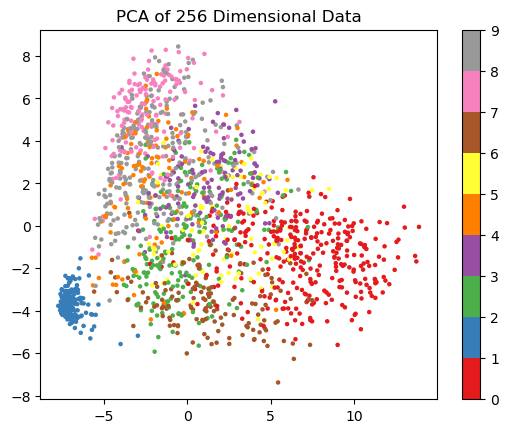

In [327]:
# Initiaze PCA
pca = PCA(n_components=2, random_state=42)

# Fit PCA to data
clouds_PCA = pca.fit_transform(X_train)

#show data
visualize(clouds_PCA, Y_train, "PCA of 256 Dimensional Data")
    

### U-MAP

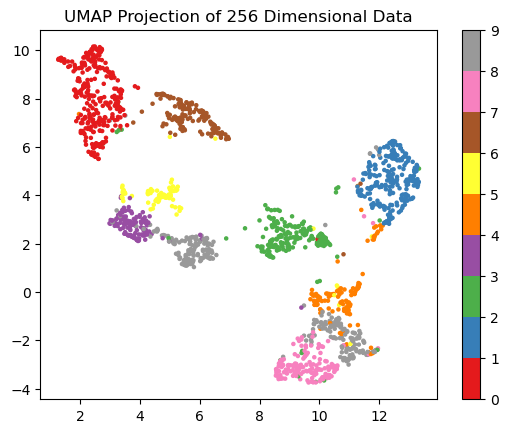

In [328]:
# initialize UMAP
umap_reducer = umap.UMAP(random_state=42)

# Fit UMAP model to data
clouds_umap = umap_reducer.fit_transform(X_train)

# show data
visualize(clouds_umap, Y_train, "UMAP Projection of 256 Dimensional Data")

### T-SNE

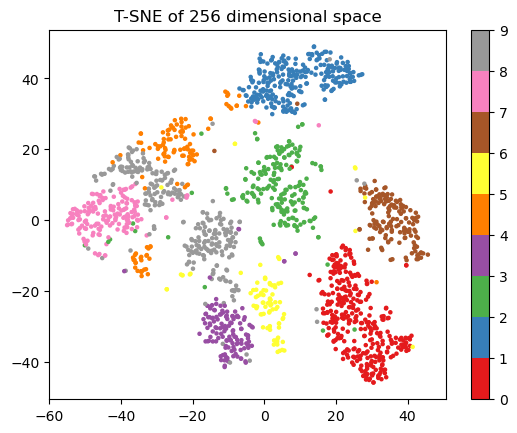

In [329]:
#Initialize T-SNE
tsne = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42)

# Fit TSNE model to data
cloud_tsne = tsne.fit_transform(X_train)

#show data
visualize(cloud_tsne, Y_train, "T-SNE of 256 dimensional space")


### Define Nearest Mean Classifier

In [330]:
def nearest_mean_classifier(new_vectors):
    Y_predict = []

    for v in new_vectors:
        distances_to_clouds = [LNG.norm(v-center) for center in cloud_centers]

        # Returns the label for the first closest cloud
        Y_predict.append(np.argmin(distances_to_clouds))
    return Y_predict

### Train K-Nearest-Neighbor Classifier

In [331]:
knn = KNeighborsClassifier(41)
knn.fit(X_train, np.ravel(Y_train))

KNeighborsClassifier(n_neighbors=41)

## Testing NearestMeanClassifier & KNearestNeighborClassifier accuracy

In [332]:
def get_accuracy(X, Y, classifier):
    correct = 0

    Y_predict = classifier(X)

    for y_predict, y in zip(Y_predict, Y):
        if y_predict == y:
            correct+=1
     
    accuracy_score(Y, Y_predict)
    return round(correct / X.shape[0] * 100, 2)

# def get_accuracy(X, Y, classifier):
#     return round(accuracy_score(Y, classifier(X)) * 100, 2)


### Accurracy on training set

In [333]:
nm_acc = get_accuracy(X_train, Y_train, nearest_mean_classifier)
print(f'Nearest Mean accuracy on training set: {nm_acc}%')

knn_acc = get_accuracy(X_train, Y_train, knn.predict)
print(f'KNN accuracy on training set: {knn_acc}%')

Nearest Mean accuracy on training set: 86.35%
KNN accuracy on training set: 88.99%


### Accurracy on test set

In [334]:
nm_acc = get_accuracy(X_test, Y_test, nearest_mean_classifier)
print(f'Nearest Mean accuracy on test set: {nm_acc}%')

knn_acc = get_accuracy(X_test, Y_test, knn.predict)
print(f'KNN accuracy on test set: {knn_acc}%')

Nearest Mean accuracy on test set: 80.4%
KNN accuracy on test set: 84.4%


### Confusion Matrix

Nearest Mean confusion matrix on the train sets


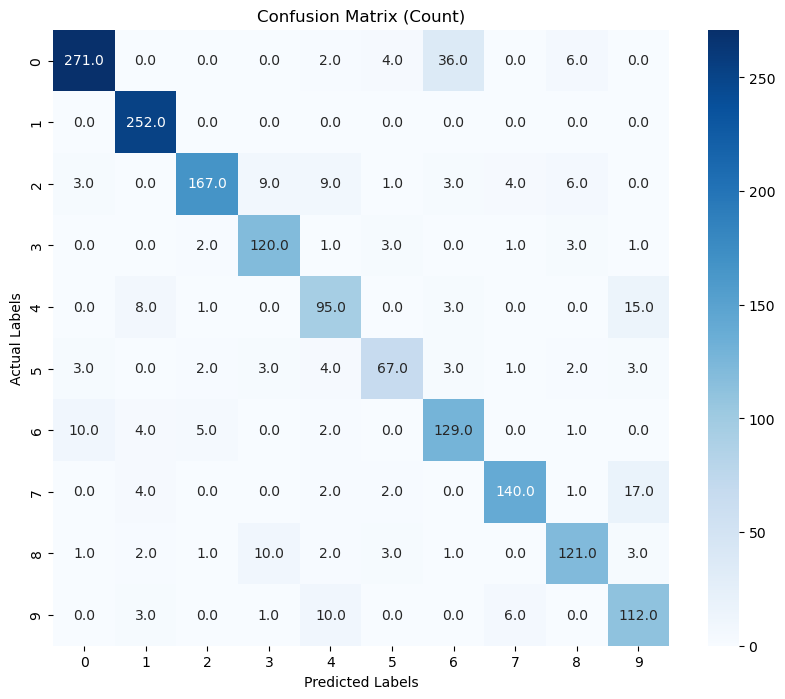

Nearest Mean confusion matrix on the test sets


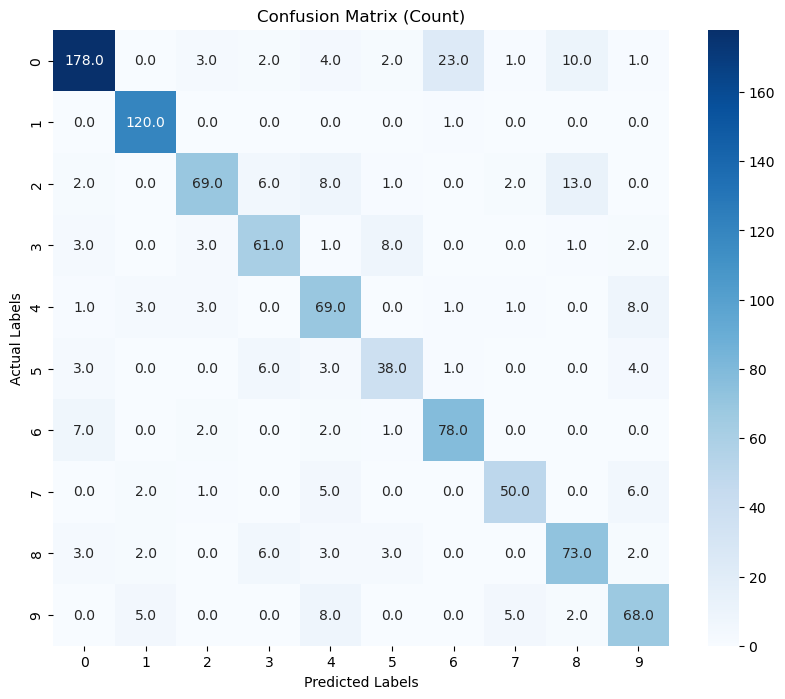

KNN confusion matrix on the train sets


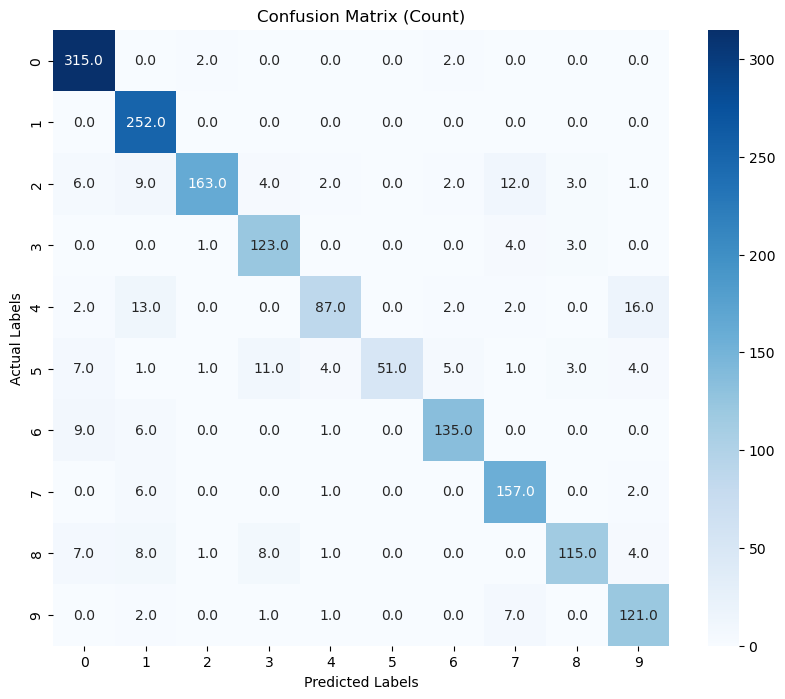

KNN confusion matrix on the test sets


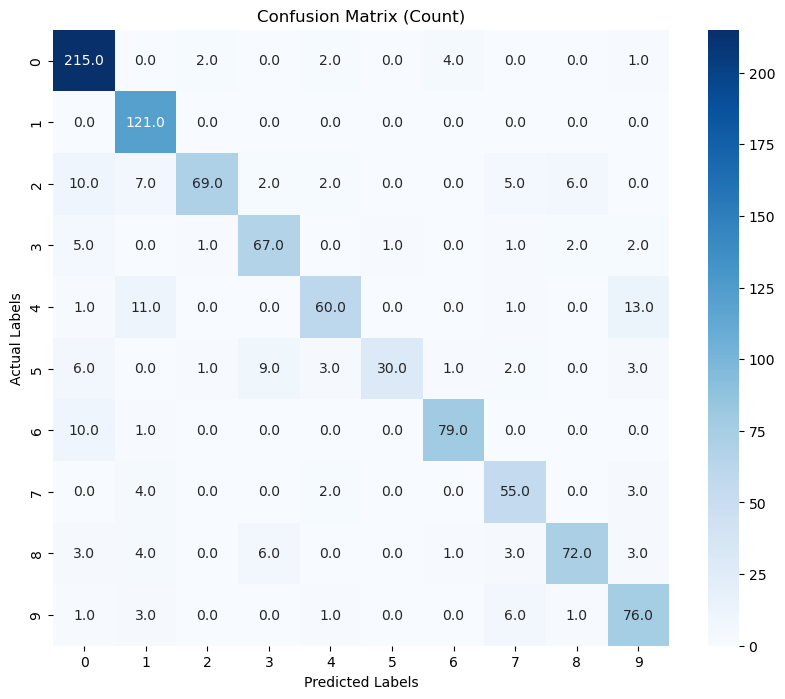

In [335]:
Y_predict_nmc = nearest_mean_classifier(X_train)
Y_predict_knn = knn.predict(X_train)
Y_test_predict_nmc = nearest_mean_classifier(X_test)
Y_test_predict_knn = knn.predict(X_test)

confusion_matrix_nmc = confusion_matrix(Y_train, Y_predict_nmc)
confusion_matrix_nmc_test = confusion_matrix(Y_test, Y_test_predict_nmc)

confusion_matrix_knn = confusion_matrix(Y_train, Y_predict_knn)
confusion_matrix_knn_test = confusion_matrix(Y_test, Y_test_predict_knn)

print(f'Nearest Mean confusion matrix on the train sets')
visualize_confusion_matrix(confusion_matrix_nmc)
print(f'Nearest Mean confusion matrix on the test sets')
visualize_confusion_matrix(confusion_matrix_nmc_test)

print(f'KNN confusion matrix on the train sets')
visualize_confusion_matrix(confusion_matrix_knn)
print(f'KNN confusion matrix on the test sets')
visualize_confusion_matrix(confusion_matrix_knn_test)


![](delta-rule1.png)

In [336]:
# slide page 13 lecture 2
# sigmoid function: ϕ(x)=1/(1+exp(-x))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# ϕ(x)=1/(1+exp(-x)) we have: ϕʹ(x)=ϕ(x)(1-ϕ(x))=output(1-output)
# so once we know ϕ(x) we also know ϕʹ(x) !
def sigmoid_derivative(x):
    return x * (1 - x)

# initialize random weights, multiply by 0.01 to get small values for improving learning rate
weights = np.random.randn(257, 10) * 0.01


def perceptron(input, labels, alpha, epochs):
    np.random.seed(42) 
    w = weights
    for epoch in range(epochs):
        for key in range(input.shape[0]):
            output = np.dot(input[key], w)
            output_sigmoid = sigmoid(output)

            target = np.zeros(10)
            target[labels[key]] = 1

            error = sigmoid_derivative(
                output_sigmoid) * (target - output_sigmoid)

            # update weights
            w = w + alpha * np.outer(input[key], error)

        if epoch % 10 == 0:
            # Compute accuracy for training set
            output_training = np.dot(input, w)
            predictions = np.argmax(sigmoid(output_training), axis=1)
            accuracy = np.mean(predictions == labels)
            print(f"Epoch {epoch}, Training Set Accuracy: {accuracy}")

            # Compute accuracy for test set
            output_test = np.dot(np.hstack([X_test, np.ones((X_test.shape[0], 1))]), w)
            predictions = np.argmax(sigmoid(output_test), axis=1)
            accuracy = np.mean(predictions == Y_test.flatten())
            print(f"Epoch {epoch}, Test Set Accuracy: {accuracy} \n****************************************")

alpha = 0.01
epochs = 100

perceptron(
    # add bias to input
    np.hstack([X_train, np.ones((X_train.shape[0], 1))]),
    Y_train.flatten(),
    alpha,
    epochs
)


Epoch 0, Training Set Accuracy: 0.8980667838312829
Epoch 0, Test Set Accuracy: 0.842 
****************************************
Epoch 10, Training Set Accuracy: 0.9595782073813708
Epoch 10, Test Set Accuracy: 0.885 
****************************************
Epoch 20, Training Set Accuracy: 0.968365553602812
Epoch 20, Test Set Accuracy: 0.89 
****************************************
Epoch 30, Training Set Accuracy: 0.9730521382542472
Epoch 30, Test Set Accuracy: 0.887 
****************************************
Epoch 40, Training Set Accuracy: 0.9765670767428236
Epoch 40, Test Set Accuracy: 0.893 
****************************************
Epoch 50, Training Set Accuracy: 0.9800820152314001
Epoch 50, Test Set Accuracy: 0.893 
****************************************
Epoch 60, Training Set Accuracy: 0.9806678383128296
Epoch 60, Test Set Accuracy: 0.894 
****************************************
Epoch 70, Training Set Accuracy: 0.9818394844756884
Epoch 70, Test Set Accuracy: 0.893 
*************

# Task 3

Text(0.5, 1.0, 'Loss by Epoch')

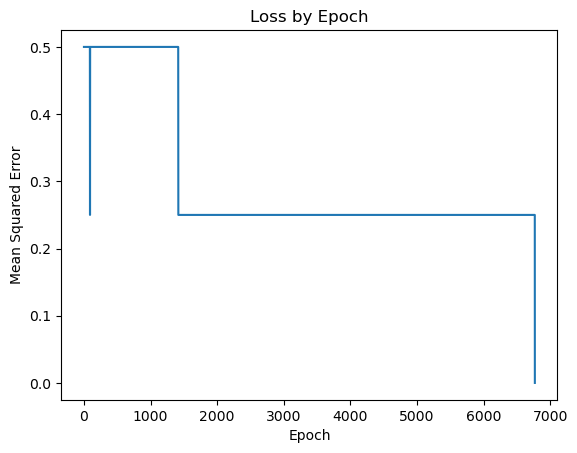

In [340]:
X_train = np.array([
    [0,0],
    [0,1],
    [1,0],
    [1,1]
])

Y_train = np.array([
    0,
    1,
    1,
    0
])

def xor_net(inputs, weights):
    # weights 0-5 are layer 1
    # weights 6-9 are layer 2
    pass

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(a):
    return a * (1 - a)

def mse(Y_pred, Y_true):
    return np.mean(np.square(Y_pred - Y_true))

def predict(x):
    #Forward Layer 1
    z1 = np.dot(x, w1) + b1
    a1 = sigmoid(z1)

    #Forward Layer 2
    z2 = np.dot(a1, w2) + b2
    a2 = sigmoid(z2)

    return round(a2.item())

# Monitoring loss
training_stats = []

# weights
w1 = np.random.normal(0, 0.1, (2,2))
b1 = np.ones((1, 2))
w2 = np.random.normal(0, 0.1, (2, 1))
b2 = np.ones((1, 1))

learning_rate = 0.1
loss = 1
epoch = 0

max_epochs = 10000
max_loss = 0.01

# training
while loss > max_loss and epoch < max_epochs:
    for x, y in zip(X_train, Y_train):
        # Feedforward
        z1 = np.dot(x, w1) + b1
        a1 = sigmoid(z1)
        z2 = np.dot(a1, w2) + b2
        a2 = sigmoid(z2)

        # Backpropagation
        dJ_da2 = a2 - y
        da2_dz2 = sigmoid_derivative(a2)
        dz2_dw2 = a1
        dJ_dw2 = np.dot(dz2_dw2.T, dJ_da2 * da2_dz2)

        da2_da1 = w2
        da1_dz1 = sigmoid_derivative(a1)
        dz1_dw1 = x.reshape(-1, 1)
        dJ_dw1 = np.dot(dz1_dw1, (dJ_da2 * da2_dz2 * da2_da1.T * da1_dz1))

        w1 -= learning_rate * dJ_dw1
        w2 -= learning_rate * dJ_dw2
        b1 -= learning_rate * np.sum(dJ_da2 * da2_dz2 * da2_da1.T * da1_dz1, axis=0)
        b2 -= learning_rate * np.sum(dJ_da2 * da2_dz2, axis=0)

    Y_pred = np.apply_along_axis(predict, 1, X_train)
    loss = mse(Y_pred, Y_train)
    
    training_stats.append([epoch, loss])
    epoch += 1

#Visualize training data
epochs, loss = zip(*training_stats)

plt.plot(epochs, loss)
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title("Loss by Epoch") 